In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from unet.unet_helpers import *
from unet.unet import UNet
from unet.utils import PixelWeightCrossEntropyLoss, visualize_sample

In [3]:
## Not very elegant but removes all the warnings about deprecated upsample funtion
import warnings
warnings.filterwarnings("ignore")

In [4]:
labels = [0,1,2]
label_thresh = [10,240]
mask_label_info = [labels, label_thresh]
rescale_to = (128,128)
split_samples = None
top = True
pixel_weights = (1,10)

use_set = 'set23'
bottom = './'+use_set+'/bottom/'
top = './'+use_set+'/top/'
mask = './'+use_set+'/masks/'
# Original images
transformations = transforms.Compose([Rescale(rescale_to), ToTensor()])
etching_dataset = MicroscopeImageDataset(name='base',
                                         img_dir=[bottom, top], 
                                         mask_dir=mask,
                                         mask_label_info=mask_label_info, read_top=top,
                                         transf=transformations, split_samples=split_samples, 
                                         pixel_weights=pixel_weights)

# Contrast, brightness adjusted
transformations = transforms.Compose([Rescale(rescale_to), 
                                      BrightnessContrastAdjustment((-0.3,1.3), 'brightness'), 
                                      ToTensor()])
etching_dataset_bc = MicroscopeImageDataset(name='bright',
                                        img_dir=[bottom, top], 
                                         mask_dir=mask,
                                         mask_label_info=mask_label_info, read_top=top,
                                         transf=transformations, split_samples=split_samples,
                                            pixel_weights=pixel_weights)

# Rotated by 90 degrees
transformations = transforms.Compose([Rescale(rescale_to), 
                                      Rotate(90), 
                                      ToTensor()])
etching_dataset_rotate = MicroscopeImageDataset(name='rotate', img_dir=[bottom, top], 
                                         mask_dir=mask,
                                         mask_label_info=mask_label_info, read_top=top,
                                         transf=transformations, split_samples=split_samples,
                                            pixel_weights=pixel_weights)

combined_dset = ConcatDatasets(etching_dataset, etching_dataset_bc, etching_dataset_rotate)
print("Total nbr of samples: {0}".format(len(combined_dset)))

Class frequecies:
0.0 38.47% of pixels
1.0 10.76% of pixels
2.0 50.77% of pixels
Class frequecies:
0.0 38.47% of pixels
1.0 10.76% of pixels
2.0 50.77% of pixels
Class frequecies:
0.0 38.47% of pixels
1.0 11.45% of pixels
2.0 50.07% of pixels
Total nbr of samples: 69


In [12]:
sample = combined_dset[60]
sample['mask'].unique()

tensor([0, 1, 2])

In [ ]:
axes = []
for i, sample in enumerate(combined_dset):
    if i==25:
        break
    fig = plt.figure(figsize=(14,4))
    axes.append(visualize_sample(fig, sample, sample['weight'], cmaps=['','','','RdYlBu']))

In [ ]:
# Enable if only one channel input
#combined_dset.top()

In [5]:
# U-Net definition

#for i,sample in enumerate(combined_dset):
 #   print("Sample {0}".format(i+1))
  #  print(list(sample['image'].shape))
input_shape = list(combined_dset[0]['image'].shape)
print(input_shape)
depth = 3
n_filters = 2

model = UNet(input_shape, n_classes=len(labels), depth=depth, wf=n_filters, padding=2, kernel_size=5, up_mode='upconv', batch_norm=True, name='test')
model.summary()

[2, 128, 128]
 
U-Net 'test'
Depth               Layer               Input shape         Output shape        Trainable params    
0                   ConvBlock           [2, 128, 128]       [4, 128, 128]       624
0                   maxpool_2           [4, 128, 128]       [4, 64, 64]         0

1                   ConvBlock           [4, 64, 64]         [8, 64, 64]         2448
1                   maxpool_2           [8, 64, 64]         [8, 32, 32]         0

2                   ConvBlock           [8, 32, 32]         [16, 32, 32]        9696

1                   ConvTransposeLayer  [16, 32, 32]        [8, 64, 64]         520
1                   ConvLayer           [8, 64, 64]         [8, 64, 64]         4848

0                   ConvTransposeLayer  [8, 64, 64]         [4, 128, 128]       132
0                   ConvLayer           [4, 128, 128]       [4, 128, 128]       1224

0                   Output: Conv2d      [4, 128, 128]       [3, 128, 128]       15

-------------------------

In [6]:
# Train parameter
batch_size = 10
epochs = 15
eta = 3e-2/batch_size
lambda_l2 = 1e-3
gamma = 0.7

In [7]:
optim = torch.optim.SGD(model.parameters(), lr=eta, momentum=gamma)
#criterion = torch.nn.CrossEntropyLoss(weight=loss_weights)
# Use pixel-weighted cross entropy loss instead
criterion = PixelWeightCrossEntropyLoss(aggregate='mean')
dataloader = DataLoader(combined_dset, batch_size=batch_size,
                        shuffle=True, num_workers=4)

avg_epoch_loss, model = train_unet(model, optim, criterion, dataloader, 
                                   epochs=epochs, lambda_=1e-3, reg_type=None, 
                                   use_cuda=False, pixel_weights=True)

Epoch 0
PixelWeightCrossEntropyLoss: 3.992 Duration: 14.67
Epoch 1
PixelWeightCrossEntropyLoss: 3.864 Duration: 14.71
Epoch 2
PixelWeightCrossEntropyLoss: 3.809 Duration: 14.78
Epoch 3
PixelWeightCrossEntropyLoss: 3.707 Duration: 14.68
Epoch 4
PixelWeightCrossEntropyLoss: 3.658 Duration: 15.16
Epoch 5
PixelWeightCrossEntropyLoss: 3.583 Duration: 14.99
Epoch 6
PixelWeightCrossEntropyLoss: 3.525 Duration: 15.07
Epoch 7
PixelWeightCrossEntropyLoss: 3.438 Duration: 15.10
Epoch 8
PixelWeightCrossEntropyLoss: 3.358 Duration: 14.94
Epoch 9
PixelWeightCrossEntropyLoss: 3.316 Duration: 14.58
Epoch 10
PixelWeightCrossEntropyLoss: 3.291 Duration: 14.98
Epoch 11
PixelWeightCrossEntropyLoss: 3.437 Duration: 15.27
Epoch 12
PixelWeightCrossEntropyLoss: 3.188 Duration: 15.06
Epoch 13
PixelWeightCrossEntropyLoss: 3.129 Duration: 15.34
Epoch 14
PixelWeightCrossEntropyLoss: 3.041 Duration: 15.07


Text(0, 0.5, 'CrossEntropyLoss')

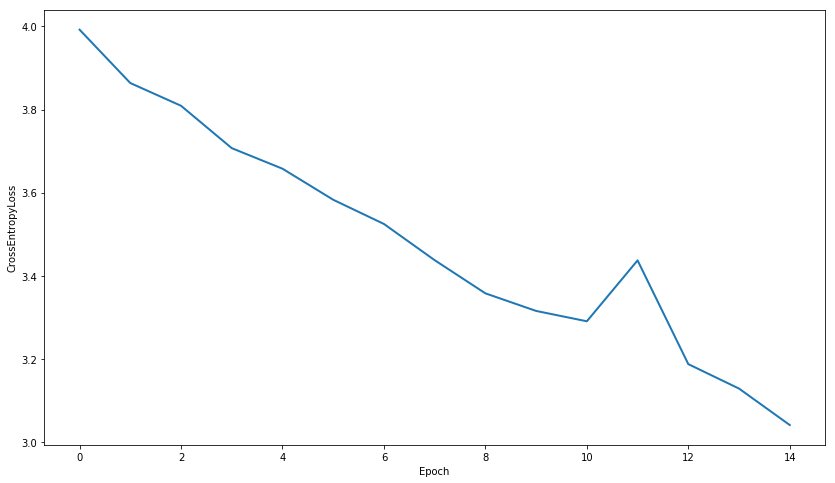

In [8]:
# Visualize
import numpy as np
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(np.arange(epochs), np.array(avg_epoch_loss), linewidth=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("CrossEntropyLoss")

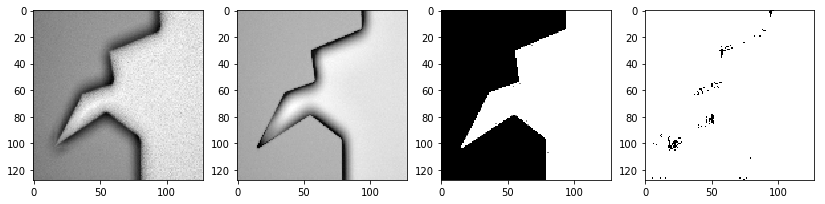

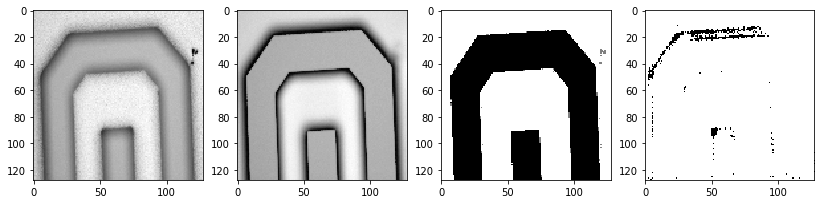

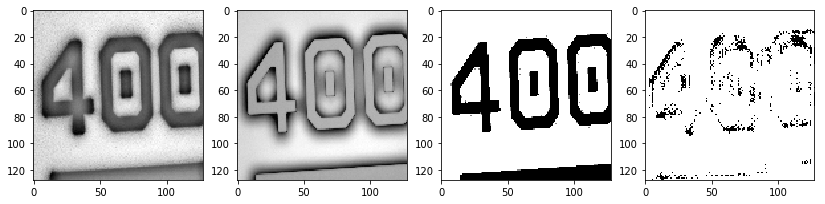

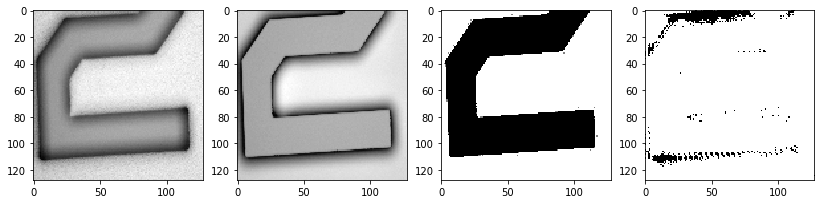

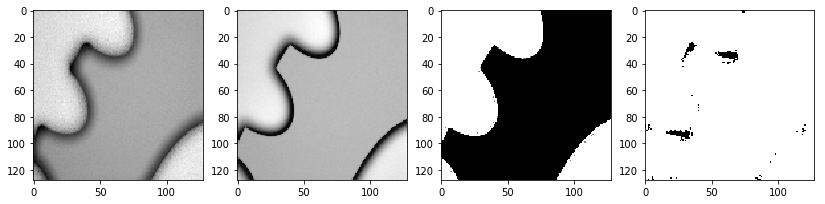

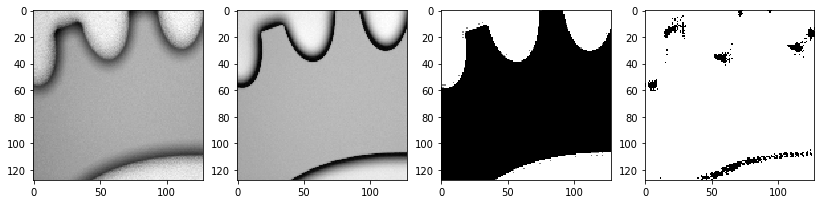

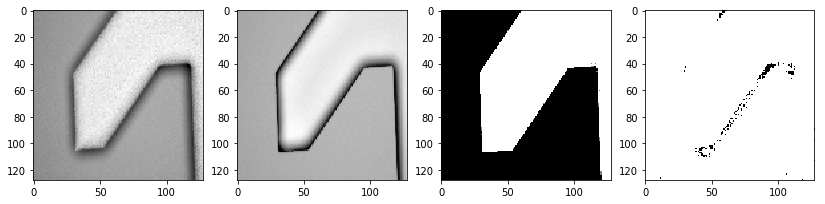

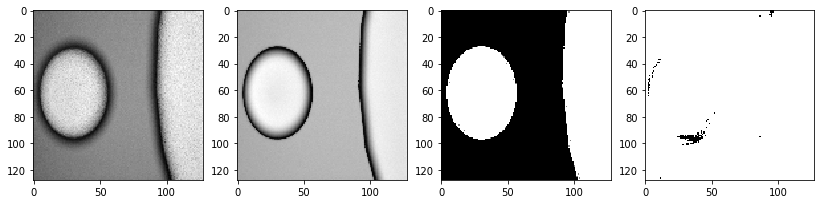

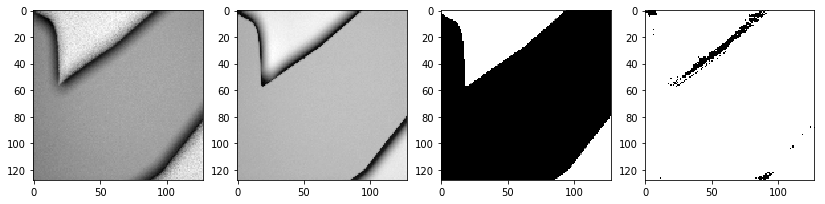

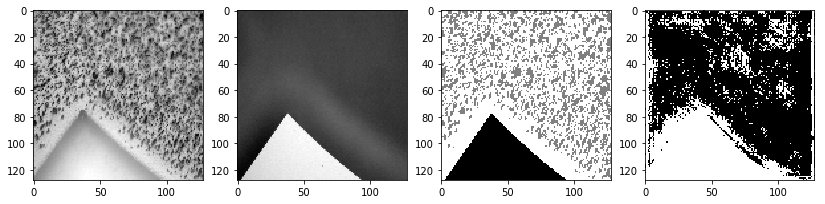

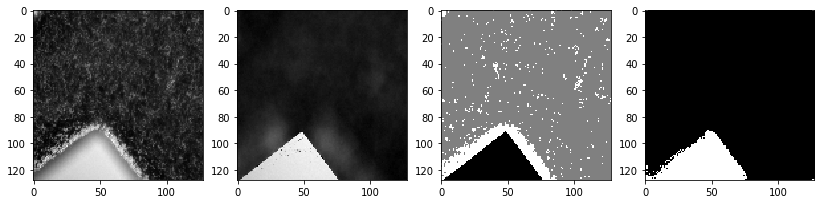

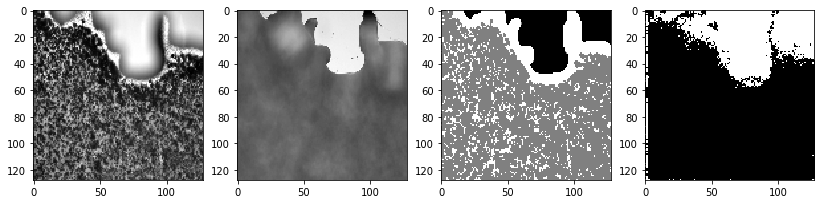

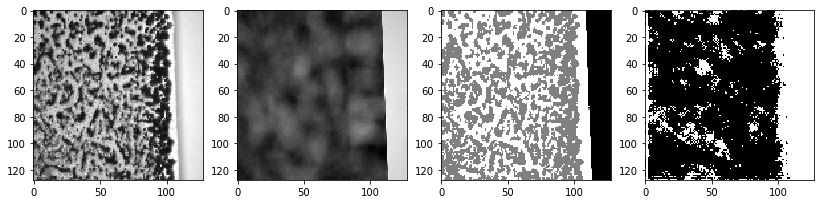

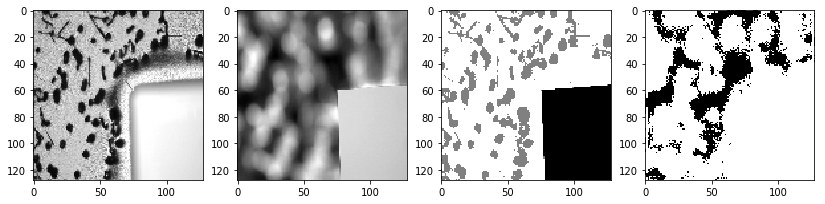

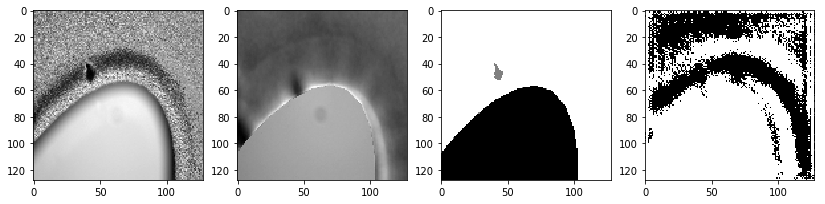

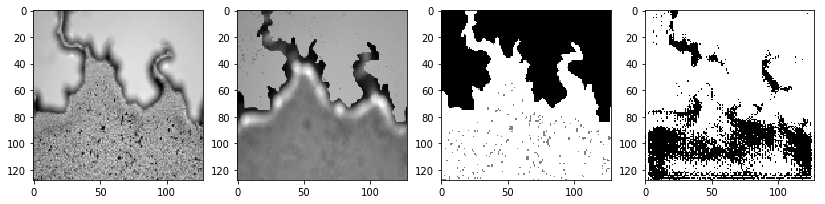

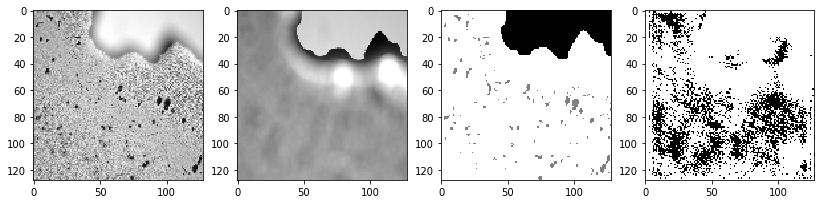

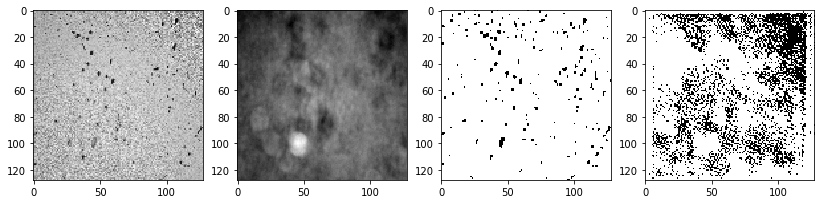

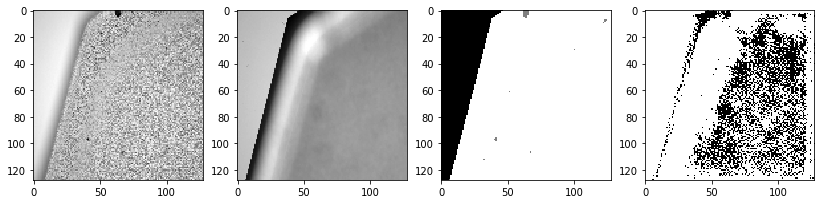

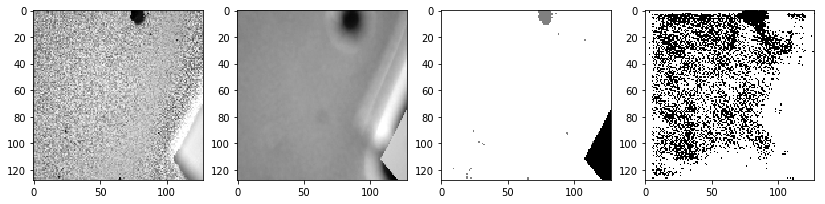

In [9]:
# Infere some samples
axes = []
for i, sample in enumerate(combined_dset):
    if i==20:
        break
    fig = plt.figure(figsize=(14,8))
    sample, infered_mask = combined_dset.infer(i, model, use_cuda=True)
    axes.append(visualize_sample(fig, sample, infered_mask))



Infere on test dataset

In [ ]:
transformations = transforms.Compose([Rescale((256,256)), ToTensor()])
test_dataset = MicroscopeImageDataset(img_dir=['./images/etching/test/bottom/','./images/etching/test/top/'], 
                                         mask_dir=None,
                                         mask_label_info=mask_label_info, read_top=True,
                                         transf=transformations, split_samples=split_samples)

In [ ]:
test_dataset.bottom()

In [ ]:
fig = plt.figure(figsize=(14,8))
i = 2
sample, infered_mask = test_dataset.infer(i, model)
axes = visualize_sample(fig, sample, infered_mask)
plt.show()